In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from metrics import dice
from data import NeuronSegmDataset

from torch import nn
import torch

from encoders import ResNetEncoders
from unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()




### Create a Fully Connected Segmentation Architecture 
This means it will work similary to any other CONV architecture, in the end it will map the dense layer into a 1,192,192 shape

In [45]:
def create_conv(in_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, out_ft, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ft),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    
    return conv



class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()
        # Create 4 conv layers with 16, 32, 64, 16 output features
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        self.conv = nn.Sequential(
            create_conv(1, 16),
            create_conv(16, 32),
            create_conv(32, 64),
            create_conv(64, 16)
        )        
        
        self.linear = nn.Linear(16*12*12, 192*192) # 4 times maxpooling with kernel 2: 192 -> 96 -> 48 -> 24 -> 12

        
    def forward(self, x):
        after_conv = self.conv(x)
        flatten = after_conv.reshape(after_conv.size(0), -1)
        lin = self.linear(flatten)
        
        # forward image trought the network, remember to reshape accordingly we want to see (BS, 1, 192, 192)
        
        
        return lin.view(x.shape[0],1,192,192)
        

### Create a Unet-Like architecture this means a network that will have the pooling path, upsampling and lateral connections.

In [196]:
def create_conv(in_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, out_ft, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    return conv

def create_upconv(in_ft, mid_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, mid_ft, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(mid_ft, out_ft, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(mode='bilinear', scale_factor=2),
    )
    return conv


class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()
        
        self.conv1 = create_conv(1, 64)
        self.conv2 = create_conv(64, 128)
        self.conv3 = create_conv(128, 256)
        self.conv4 = create_conv(256, 512)
        self.conv5 = create_conv(512, 1024)

        self.upconv1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(mode='bilinear', scale_factor=2),
        )
        self.upconv2 = create_upconv(1024, 512, 256)
        self.upconv3 = create_upconv(512, 256, 128)
        self.upconv4 = create_upconv(256, 128, 64)
        self.upconv5 = create_upconv(128, 64, 64)
        '''nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )'''
            
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        self.linear = nn.Linear(96, 192*192)
        
    
    def forward(self, x):
        #print('x: ',x.shape)
        xd64 = self.conv1(x)
        #print('xd64: ',xd64.shape)
        xd128 = self.conv2(xd64)
        #print('xd128: ',xd128.shape)
        xd256 = self.conv3(xd128)
        #print('xd256: ',xd256.shape)
        xd512 = self.conv4(xd256)
        #print('xd512: ',xd512.shape)
        xd1024 = self.conv5(xd512)
        #print('xd1024: ',xd1024.shape)
        
        xu512 = self.upconv1(xd1024)
        #print('xu512: ',xu512.shape)
        #print('concat:',torch.cat((xu512,xd512), 1).shape)
        
        xu256 = self.upconv2(torch.cat((xu512,xd512), 1))
        
        xu128 = self.upconv3(torch.cat((xu256,xd256), 1))
        
        xu64 = self.upconv4(torch.cat((xu128,xd128), 1))
        
        xu64b = self.upconv5(torch.cat( (xu64,xd64), 1))
        #print('xu64b: ',xu64b.shape)
        
        x = self.output(xu64b)
        
        return x

In [215]:
def create_conv(in_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, out_ft, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    return conv

def create_upconv(in_ft, mid_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, mid_ft, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(mid_ft, out_ft, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(mode='bilinear', scale_factor=2),
    )
    return conv


class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()
        
        self.conv1 = create_conv(1, 2)
        self.conv2 = create_conv(2, 4)
        self.conv3 = create_conv(4, 8)
        self.conv4 = create_conv(8, 16)
        self.conv5 = create_conv(16, 32)

        self.upconv1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(mode='bilinear', scale_factor=2),
        )
        self.upconv2 = create_upconv(32, 16, 8)
        self.upconv3 = create_upconv(16, 8, 4)
        self.upconv4 = create_upconv(8, 4, 2)
        self.upconv5 = create_upconv(4, 2, 2)
        '''nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )'''
            
        self.output = nn.Conv2d(2, 1, kernel_size=1, padding=0)
        
        self.linear = nn.Linear(96, 192*192)
        
    
    def forward(self, x):
        #print('x: ',x.shape)
        xd64 = self.conv1(x)
        #print('xd64: ',xd64.shape)
        xd128 = self.conv2(xd64)
        #print('xd128: ',xd128.shape)
        xd256 = self.conv3(xd128)
        #print('xd256: ',xd256.shape)
        xd512 = self.conv4(xd256)
        #print('xd512: ',xd512.shape)
        xd1024 = self.conv5(xd512)
        #print('xd1024: ',xd1024.shape)
        
        xu512 = self.upconv1(xd1024)
        #print('xu512: ',xu512.shape)
        #print('concat:',torch.cat((xu512,xd512), 1).shape)
        
        xu256 = self.upconv2(torch.cat((xu512,xd512), 1))
        
        xu128 = self.upconv3(torch.cat((xu256,xd256), 1))
        
        xu64 = self.upconv4(torch.cat((xu128,xd128), 1))
        
        xu64b = self.upconv5(torch.cat( (xu64,xd64), 1))
        #print('xu64b: ',xu64b.shape)
        
        x = self.output(xu64b)
        
        return x

In [216]:
neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
               VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AlaUnet().to(DEVICE)
# model = SSN().to(DEVICE)

optim = torch.optim.Adam(model.parameters())
epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
dice 0.8632638451471422
loss 0.5855581
train_dice 0.8798364163516563
train_loss 0.5704582
time: 1.7344188690185547
epoch 1
dice 0.8632638451471422
loss 0.5765355
train_dice 0.8864037518943926
train_loss 0.55314755
time: 1.542834997177124
epoch 2
dice 0.8632638451471422
loss 0.5430947
train_dice 0.8810688100200771
train_loss 0.5142402
time: 1.4943660895029705
epoch 3
dice 0.8632638451471422
loss 0.5431336
train_dice 0.8696590919025132
train_loss 0.52895814
time: 1.472362995147705
epoch 4
dice 0.8632638451471422
loss 0.54048574
train_dice 0.8809885671586608
train_loss 0.50429606
time: 1.458571767807007
epoch 5
dice 0.8632638451471422
loss 0.5392495
train_dice 0.8797453711585055
train_loss 0.5055961
time: 1.4436081647872925
epoch 6
dice 0.8632638451471422
loss 0.5353691
train_dice 0.866593114486112
train_loss 0.5261237
time: 1.4253197056906564
epoch 7
dice 0.8632638451471422
loss 0.5296053
train_dice 0.8672947114153039
train_loss 0.5210268
time: 1.4130048751831055
epoch 8
dice 0.8

epoch 66
dice 0.8816788063491489
loss 0.38182467
train_dice 0.8961179470068336
train_loss 0.3486173
time: 1.3924772098882874
epoch 67
dice 0.8818341059904571
loss 0.38029823
train_dice 0.8957729689067645
train_loss 0.349279
time: 1.3931457645752852
epoch 68
dice 0.8809590137446331
loss 0.3818475
train_dice 0.884811834621014
train_loss 0.37513947
time: 1.3929203213125034
epoch 69
dice 0.8834476527824131
loss 0.3855601
train_dice 0.8925308401538152
train_loss 0.3644451
time: 1.3938347441809518
epoch 70
dice 0.8773955785123885
loss 0.3893731
train_dice 0.891531786293711
train_loss 0.3645225
time: 1.3928439012715514
epoch 71
dice 0.8837737538378017
loss 0.38111266
train_dice 0.8933370879540377
train_loss 0.36202967
time: 1.3923207355870142
epoch 72
dice 0.8841361794771506
loss 0.37705684
train_dice 0.891112941202977
train_loss 0.36280364
time: 1.3918624283516243
epoch 73
dice 0.8847107324260046
loss 0.37668377
train_dice 0.9019378110814841
train_loss 0.33236757
time: 1.3916806240339537
epo

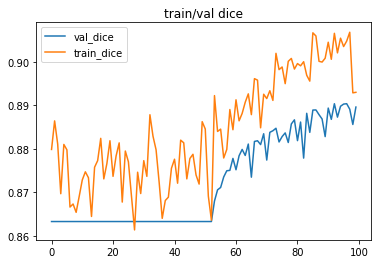

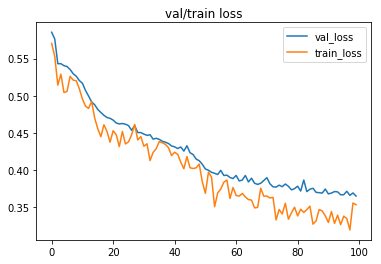

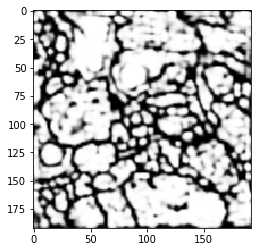

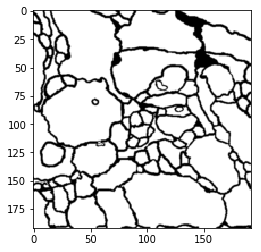

In [217]:
epochs=100
import time
tick = time.time()

for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)
    
    print("epoch", i)
    print('dice', val_mean_dice)
    print('loss', val_loss)
    print('train_dice', train_mean_dice)
    print('train_loss', train_loss)
    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    tock = time.time()
    print(f'time: {(tock-tick)/(i+1)}')
    

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')


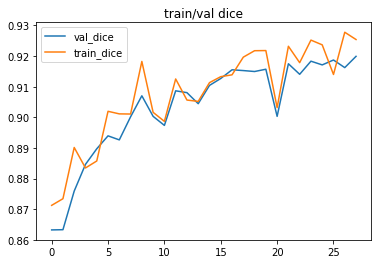

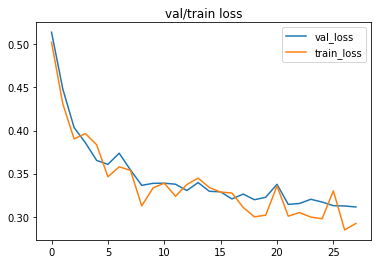

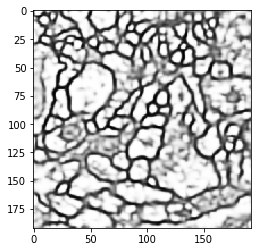

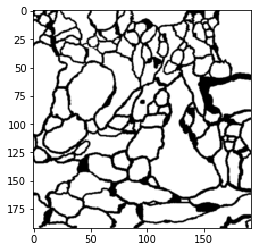

In [202]:
df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')

In [ ]:
import PIL
img = PIL.Image.open('pikachu2.jpg').convert('L').crop((80, 60, 80 + 192, 60 +192))
trans = transforms.ToTensor()
im = trans(img)
#im.shape
pred = model(im.unsqueeze(dim = 0))
plt.imshow(pred.detach().squeeze().numpy(), cmap = 'gray')